## MLE computation

compute the MLE to check quality of estimates and code functionality.

In [1]:
using Pkg
Pkg.activate("C:/Users/lisah/Documents/Repos/ma-code")

  Activating project at `C:\Users\lisah\Documents\Repos\ma-code`


In [2]:
include("c:/Users/lisah/Documents/Repos/ma-code/src/src.jl")
using .Src

In [3]:
using DataFrames, Optim, Plots, ForwardDiff, LinearAlgebra

### create simulated data obs

In [4]:
# set some random system parameters
a_true = 1.1
n0_true = 2.3
noise = 0.1
M = 100

hprm = Src.Hyperprm(0.95, n0_true, a_true, 0.45, M, noise);

In [5]:
# generate true data, i.e. data observations
sol_true = Src.sol_klausmeier(hprm; t_fixed=true, t_end=100.0) 
sol_true = Src.randomize_data!(sol_true, hprm.noise); # make data noisy


### experiment for single sample

In [6]:
# compute MLE
mle, success = Src.compute_mle(hprm, sol_true; t_fixed=true, t_end=100.0) # compute MLE
print("[a_mle, n0_mle] = $mle")

[a_mle, n0_mle] = [1.0996920466496358, 2.320464391761817]

In [17]:
# compute Fi evaluated at MLE and at true prm point
# compare both and see that Fi differs. Note that fi_mle must not necessarily be higher than fi_true

fi_mle = Src.compute_fi(mle, hprm, sol_true; t_fixed=true, t_end=100.0)
fi_true = Src.compute_fi([a_true,n0_true], hprm, sol_true; t_fixed=true, t_end=100.0)

print("fi_mle, fi_true = $fi_mle, $fi_true")

fi_mle, fi_true = 920.3025903886927, 857.8251251711222

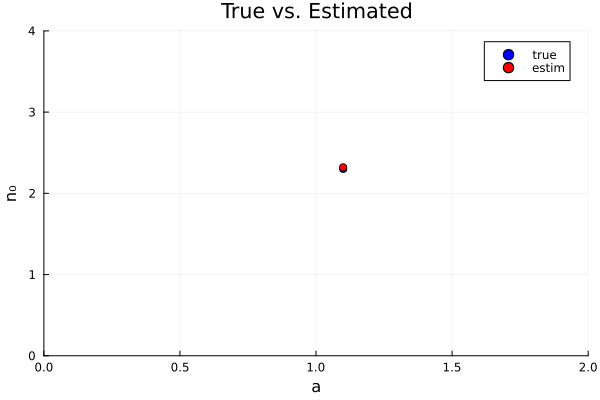

In [7]:
# plot true prm vs MLE
scatter([a_true], [n0_true], label = "true", color = :blue,xlabel = "a", ylabel = "n₀", xlims = (0, 2), ylims = (0, 4),legend = :topright,title = "True vs. Estimated")
scatter!([mle[1]], [mle[2]], label = "estim", color = :red)

I checked the corresponding log-likelihood plots for different points and noise levels and the MLEs visually fit the maxima of the respective log-likelihood functions.

### multiple restart opim

In [ ]:
N = 20
inits, inits_loss, mles, losses, best_loss_ind, converged = Src.mult_restart_mle(N, hprm, sol_true, t_fixed=true, t_end=100.0); # Q: right now for a, n0 prm 

#### Plots

In [65]:
function plot_mult_restart_mles(inits::Matrix, mles::Matrix, ind_best::Int64; compare::Bool=true)
    plot(mles[:,1], label="MLEs", title="Multiple restart MLE of a",color=:orange, ylabel="parameter value", xlabel="restart index")
    hline!([hprm.a], linestyle=:dash, linewidth=2, color=:black,  label="true parameter")
    scatter!(1:N, mles[:,1], markershape=:square, markersize=2, color=:orange, label="")

    if compare
        plot!(inits[:,1], label="inits", color=:blue)
        scatter!(1:N, inits[:,1], markershape=:square, markersize=2, color=:blue, label="")
    end
    scatter!([best_loss_ind], [mles[best_loss_ind, 1]], markershape=:x, markerstrokewidth=4, markersize=6, color=:red, label="best estimate")
end

function plot_mult_restart_losses(inits_loss::Vector, losses::Vector, ind_best::Int64; compare::Bool=true)
    plot(losses, label="MLEs", color=:darkorange, title="Loss evolution of multiple restart MLE", ylabel = "loss value", xlabel="restart index")
    scatter!(1:N, losses, markershape=:square, markersize=2, color=:darkorange, label="")

    if compare
        plot!(inits_loss, label="init", color=:blue)
        scatter!(1:N, inits_loss, markershape=:square, markersize=2, color=:blue, label="")
    end

    scatter!([best_loss_ind], [losses[best_loss_ind]], markershape=:x, markerstrokewidth=4, markersize=6, color=:red, label="lowest")
end

plot_mult_restart_losses (generic function with 1 method)

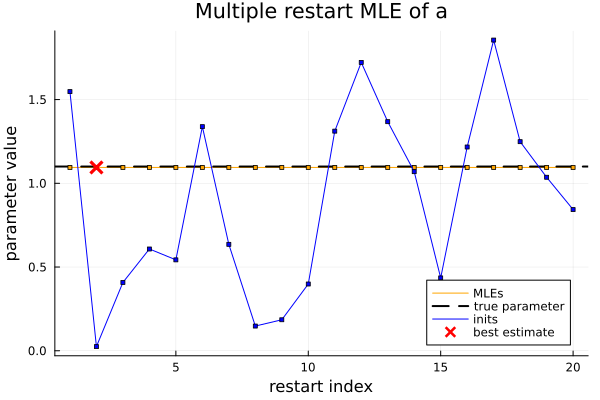

In [95]:
# plot inits vs. mles
plot_mult_restart_mles(inits, mles, best_loss_ind)

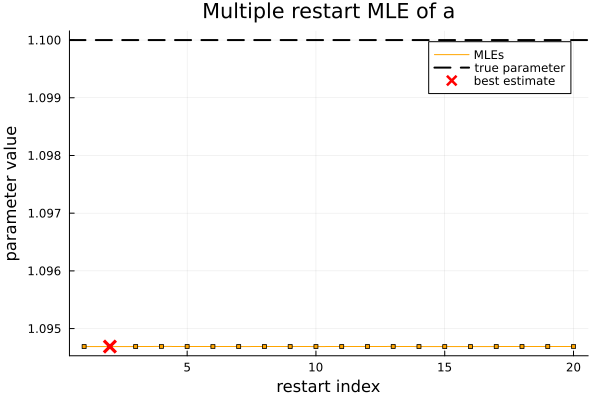

In [97]:
plot_mult_restart_mles(inits, mles, best_loss_ind, compare=false)

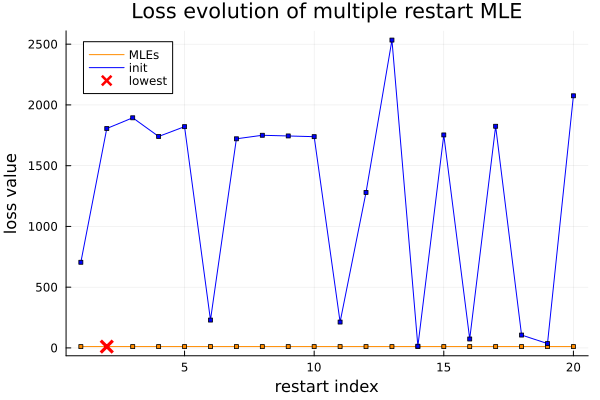

In [70]:
# plot losses
plot_mult_restart_losses(inits_loss, losses, best_loss_ind)

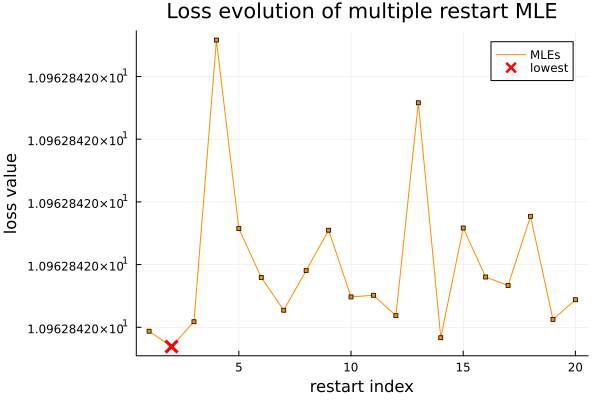

In [71]:
plot_mult_restart_losses(inits_loss, losses, best_loss_ind, compare=false)

I tried out different regimes of a.
Identifiability differs depending on whether a is left or right to the bifurcation point. 
If a right of bifurcation point, there appears to be another local minimum -> not practically identifiable!

TODO:
- plot profile likelihood
- check loss: why are the values so high? and so different -> there seems to be a local minimum far away
- why are values positive? -> makes sense: ll is negative, thus nll is positive
- why is loss so high? normal? -> sollte schon passen (zumindest ist loss ~0, wenn noise=0.0)

### analyze correlation matrix

In [131]:
eval_pt = mles[best_loss_ind,:] # Q: should be MLE or what?

2-element Vector{Float64}:
 1.0946885255743128
 2.2799874472456065

inverse of the FIM is approximation of the covariance matrix -> rescale to get parameter correlations (source: tools paper)

In [146]:
function correlation_matrix(eval_pt::Vector{Float64}, hprm::Src.Hyperprm, true_val::DataFrame; t_fixed::Bool=false, t_end::Float64=50.0, t_step::Float64=1.0)
    fim = - ForwardDiff.hessian(x -> Src.compute_ll(x, hprm, true_val; t_fixed=t_fixed, t_end=t_end, t_step=t_step), eval_pt)
    cov = inv(fim)
    cor = [cov[i,j] / sqrt(cov[i,i]*cov[j,j]) for i in range(1, size(cov,1)), j in range(1, size(cov,2))]
    return cor
end

correlation_matrix(eval_pt, hprm, sol_true, t_fixed=true, t_end=100.0)

2×2 Matrix{Float64}:
  1.0        -0.0924752
 -0.0924752   1.0